I'm using Allison Parrish's [Python port](https://github.com/aparrish/pytracery) of Kate Compton's [Tracery](http://tracery.io/) text expansion library.

> Tracery implements a standard context-free grammar, and extends it with more powerful features that allow the users some additional control while still minimizing tedious metadata authoring. ... Three types of rewrite rules give the user control over the expansion of a symbol: terminals (an unexpandable string), symbols (demarked with hash tags like "#animal#"), and modifiers (preceded with a period: "#animal.capitalize#) 
> 
> — *[Tracery: Approachable Story Grammar Authoring for Casual Users](https://www.aaai.org/ocs/index.php/INT/INT7/paper/viewFile/9266/9216)*


[ABC text-based music notation](http://abcnotation.com/)

My `show(abc)` function shows ABC in a Jupyter Notebook, with 3 representations:
- Text
- Musical Notation
- MIDI rendered to WAV

It's currently a rough hack, and requires [a soundfont](http://schristiancollins.com/generaluser.php) and several cross-platform command line tools:
- [abcm2ps](http://abcplus.sourceforge.net/#abcm2ps)
- [abc2midi](http://abcplus.sourceforge.net/#abcmidi)
- [fluidsynth](http://www.fluidsynth.org/) (included with [Qsynth](https://sourceforge.net/projects/qsynth/))

In [1]:
from IPython.display import Audio, display, SVG
import os
import subprocess
from uuid import uuid4

def show(abc):
    base_filename = str(uuid4())
    abc_filename = base_filename + '.abc'
    midi_filename = base_filename + '.mid'
    svg_filename = 'Out001.svg'
    wav_filename = base_filename + '.wav'
    soundfont_path = './GeneralUser GS v1.471.sf2'
    
    with open(abc_filename, 'w') as f:
        f.write(abc)
    
    print(abc)
    
    subprocess.run(['abcm2ps', '-g', abc_filename])
    display(SVG(filename=svg_filename))
    
    subprocess.run(['abc2midi', abc_filename, '-o', midi_filename])
    subprocess.run(['fluidsynth', '-i', '-F', wav_filename, soundfont_path, midi_filename])
    display(Audio(filename=wav_filename))
                                
    os.remove(abc_filename)     
    os.remove(midi_filename)
    os.remove(svg_filename)
    os.remove(wav_filename)

 
X: 1
%%titleleft 1
T: One note
M: 2/4
L: 1/16
Q: 100
C: 
K: G
%%MIDI program 53
G16


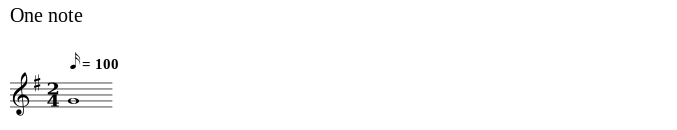

In [2]:
import tracery

header_template = '''
X: #index#
%%titleleft #titleleft#
T: #title#
M: #meter#
L: #default_note_length#
Q: #tempo#
C: #composer#
K: #key#
%%MIDI program #midi_program#
'''

header_rules = {
    'header': header_template,
    'index': '1', 
    'titleleft': '1', 
    'title': '',
    'meter': '2/4', 
    'default_note_length': '1/16', 
    'tempo': '100', 
    'composer': '', 
    'key': 'G', 
    'midi_program': '105'
}

header_grammar = tracery.Grammar(header_rules)
header = header_grammar.flatten('[title:One note][midi_program:53] #header#')
melody = 'G16'
abc =  header + melody
show(abc)

  
X: 1
%%titleleft 1
T: Mandolin
M: 2/4
L: 1/16
Q: 100
C: 
K: G
%%MIDI program 25
GGGGGGGGGGGGGGGG


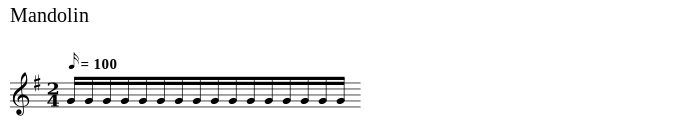

In [3]:
def mandolin_tremolo(pitch, beats):
    return pitch * beats

melody_rules = {
    'G16': mandolin_tremolo('G', 16)
}

melody_grammar = tracery.Grammar(melody_rules)
header = header_grammar.flatten('[title:Mandolin] [midi_program:25] #header#')
melody = melody_grammar.flatten('#G16#')
abc = header + melody
show(abc)

  
X: 1
%%titleleft 1
T: Banjo
M: 2/4
L: 1/16
Q: 100
C: 
K: G
%%MIDI program 105
GdgGdgGdgGdgGdgG


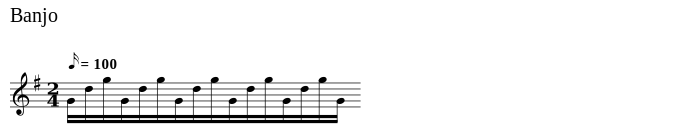

In [4]:
import itertools

def banjo_forward_roll(pitch, beats, chord='G'):
    if chord=='G': # TODO: other chords
        string1 = 'd'
        string5 = 'g'  
    pattern = itertools.cycle([pitch, string1, string5])
    return ''.join(next(pattern) for n in range(beats))

melody_rules = {
    'G16': banjo_forward_roll('G', 16)
}

melody_grammar = tracery.Grammar(melody_rules)
header = header_grammar.flatten('[title:Banjo] [midi_program:105] #header#')
melody = melody_grammar.flatten('#G16#')
abc = header + melody
show(abc)

  
X: 1
%%titleleft 1
T: Cripple Creek
M: 2/4
L: 1/16
Q: 100
C: 
K: G
%%MIDI program 53
| BBB2 BBB2 | BBBB D4 | BBB2 AGEE | D2E2 G4 |
w: Go-ing up crip-ple creek Go-ing on a run Go-ing up crip-ple creek to have some fun


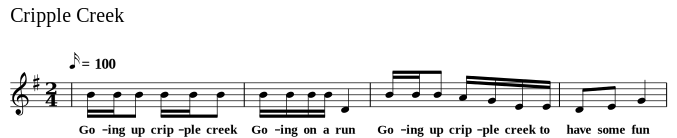

In [5]:
cripple_creek = '| BBB2 BBB2 | BBBB D4 | BBB2 AGEE | D2E2 G4 |'
lyrics = '\nw: Go-ing up crip-ple creek Go-ing on a run Go-ing up crip-ple creek to have some fun'
header = header_grammar.flatten('[title:Cripple Creek] [midi_program:53] #header#')
melody = cripple_creek
abc = header + melody + lyrics
show(abc)

  
X: 1
%%titleleft 1
T: Cripple Creek
M: 2/4
L: 1/16
Q: 100
C: 
K: G
%%MIDI program 53
| B4 B4 | B4 D4 | B4 AGE2 | D2E2 G4 |
w: Go creek Go run Go crip-ple creek have some fun


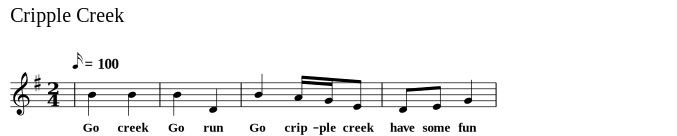

In [6]:
melody_rules = {
    'BBB2': 'B4', 
    'BBBB': 'B4', 
    'EE': 'E2'
}

melody_grammar = tracery.Grammar(melody_rules)

def mark_nonterminals(text, rules):
    for symbol in rules:
        text = text.replace(symbol, '#'+symbol+'#')
    return text

melody = melody_grammar.flatten(mark_nonterminals(cripple_creek, melody_rules))
lyrics = '\nw: Go creek Go run Go crip-ple creek have some fun'
abc = header + melody + lyrics
show(abc)

  
X: 1
%%titleleft 1
T: Cripple Creek
M: 2/4
L: 1/16
Q: 100
C: 
K: G
%%MIDI program 105
| (!bend!AB)gd (!bend!AB)gd | (!bend!AB)gd D4 | (!bend!AB)gd AGE2 | D2E2 G4 |
w: Go . . . creek . . . Go . . . run Go . . . crip-ple creek have some fun


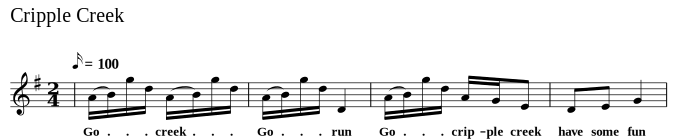

In [7]:
melody_rules = {
    'BBB2': '#B4#', 
    'BBBB': '#B4#', 
    'EE': 'E2', 
    'B4': '(!bend!AB)gd'
}

melody_grammar = tracery.Grammar(melody_rules)

header = header_grammar.flatten('[title:Cripple Creek] [midi_program:105] #header#')
melody = melody_grammar.flatten(mark_nonterminals(cripple_creek, melody_rules))
lyrics = '\nw: Go . . . creek . . . Go . . . run Go . . . crip-ple creek have some fun'
abc = header + melody + lyrics
show(abc)

[!bend!](https://ifdo.ca/~seymour/runabc/abcguide/abc2midi_body.html#bend)


X: 1
%%titleleft 1
T: I Want It That Way
M: 4/4
L: 1/8
Q: 142
C: Backstreet Boys, arranged Scruggs style
K: G
%%MIDI program 105
z2 d2 cB AG | Ad (!bend!AB) gd D2 | Ed gG dg Bd | Ad (!bend!EG) dg G2 |
w: I nev-er want to hear . you say . . . I . . want . . it . that . . way



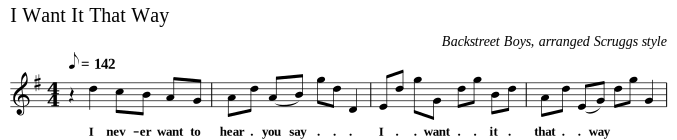

In [8]:
show('''
X: 1
%%titleleft 1
T: I Want It That Way
M: 4/4
L: 1/8
Q: 142
C: Backstreet Boys, arranged Scruggs style
K: G
%%MIDI program 105
z2 d2 cB AG | Ad (!bend!AB) gd D2 | Ed gG dg Bd | Ad (!bend!EG) dg G2 |
w: I nev-er want to hear . you say . . . I . . want . . it . that . . way
''')

Alternate MIDI generated with [TablEdit](https://www.tabledit.com/):

In [9]:
subprocess.run('fluidsynth -i -F "I Want It That Way.wav" "GeneralUser GS v1.471.sf2" "I Want It That Way.mid"', shell=True)
display(Audio(filename='I Want It That Way.wav'))

"Shave and a Haircut" ending:

In [10]:
subprocess.run('fluidsynth -i -F "Shave and a Haircut.wav" "GeneralUser GS v1.471.sf2" "Shave and a Haircut.mid"', shell=True)
display(Audio(filename='Shave and a Haircut.wav'))